In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal

In [7]:
Y_test = np.load('Y_test.npy')
PREDS_TEST_ALL = np.load('PREDS_TEST_ALL.npy')
SIGMAS_ALL = np.load('SIGMAS_ALL.npy')

In [8]:
print(Y_test.shape) # n_obs x n_vars
print(PREDS_TEST_ALL.shape) # n_models x n_obs x n_bootstraps x n_vars
print(SIGMAS_ALL.shape) # n_models x n_obs x n_vars x n_vars x n_bootstraps
M_varnns = 3

PRED_DENSITY_MARG_ALL = np.zeros((M_varnns, PREDS_TEST_ALL.shape[1], PREDS_TEST_ALL.shape[3]))
PRED_DENSITY_JOINT_ALL = np.zeros((M_varnns, PREDS_TEST_ALL.shape[1]))

for model in range(M_varnns):
  
  PREDS_TEST = PREDS_TEST_ALL[model, :,:,:] # n_obs x n_bootstraps x n_vars
  SIGMAS = SIGMAS_ALL[model, -20:,:,:,:] # n_obs x n_vars x n_vars x n_bootstraps

  # Take the mean across all bootstraps: 20 x 3
  preds_test_mean = PREDS_TEST.mean(axis=1)
  # Take the mean of all cov mats across all bootstraps. sigmas_mean: 20 x 3 x 3
  sigmas_mean = SIGMAS.mean(axis = 3)

  # Loop over all time steps
  for t in range(PREDS_TEST.shape[0]):
    pred_mean = preds_test_mean[t, :]
    pred_sigma = sigmas_mean[t, :, :]
    y_test = Y_test[t, :]
    
    ### Calculating joint density
    # Construct a multivariate normal with pred_mean and pred_sigma
    mv_norm = multivariate_normal(pred_mean, pred_sigma)
    # Evaluate the density at y_test
    log_density = mv_norm.logpdf(y_test)
    PRED_DENSITY_JOINT_ALL[model, t] = log_density
    
    ### Calculating marginal density
    for var in range(PREDS_TEST.shape[2]):
      # Construct a univariate normal with pred_mean and pred_sigma
      univ_norm = multivariate_normal(pred_mean[var], pred_sigma[var, var])
      # Evaluate the density at y_test
      log_density = univ_norm.logpdf(y_test[var])
      PRED_DENSITY_MARG_ALL[model, t, var] = log_density

(20, 3)
(12, 20, 60, 3)
(12, 247, 3, 3, 60)


In [23]:

# Make dataframe wtih sum and mean of predictive density as the 2 columns
joint_density_df = pd.DataFrame({'Mean': PRED_DENSITY_JOINT_ALL.mean(axis=1), 
                   'Median': np.median(PRED_DENSITY_JOINT_ALL, axis=1),
                   '10th': np.percentile(PRED_DENSITY_JOINT_ALL, 10, axis=1),
                   '90th': np.percentile(PRED_DENSITY_JOINT_ALL, 90, axis=1)
}, index = [0, 1, 2])

# Make dataframe wtih sum and mean of predictive density as the 2 columns
marginal_density_df = pd.DataFrame()
for var in range(3):
  marginal_density_df_var = pd.DataFrame({'Mean': PRED_DENSITY_MARG_ALL[:, :, var].mean(axis=1),
                        'Median': np.median(PRED_DENSITY_MARG_ALL[:, :, var], axis=1),
                        '10th': np.percentile(PRED_DENSITY_MARG_ALL[:, :, var], 10, axis=1),
                        '90th': np.percentile(PRED_DENSITY_MARG_ALL[:, :, var], 90, axis=1),
                        'Variable': var
                        }, index = [0, 1, 2])
  
  marginal_density_df = pd.concat([marginal_density_df, marginal_density_df_var], axis=0)
                        

In [25]:
marginal_density_df = marginal_density_df.reset_index()
# Rename index column to Model
marginal_density_df = marginal_density_df.rename(columns={'index': 'Model'})
# Subset model to 0
marginal_density_df_0 = marginal_density_df[marginal_density_df['Model'] == 0]

In [28]:
marginal_density_df_0
# (unrate, GDP, inf)

,Model,Mean,Median,10th,90th,Variable
0,0,-86.150353,0.049937,-84.336977,0.767840,0
3,0,-7.025435,4.075774,-6.646665,4.341950,1
6,0,-2.048852,4.234570,-0.350714,4.627122,2


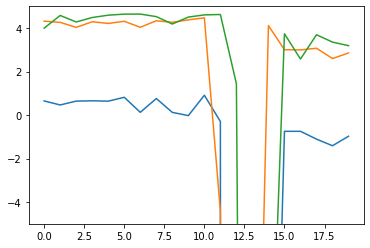

In [13]:
for var_num in range(PRED_DENSITY_MARG_ALL.shape[2]):
  plt.plot(PRED_DENSITY_MARG_ALL[0, :, var_num], label='VARNN')
  plt.ylim(-5, 5)

In [ ]:
plt.plot(PRED_DENSITY_MARG_ALL[0, :, 0], label='VARNN')
plt.ylim(-5, 5)

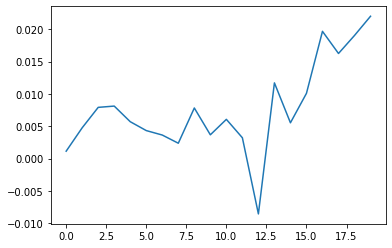

In [20]:
# Plot Y_test (unrate, GDP, inf)
plt.plot(Y_test[:, 2], label='Y_test')